In [134]:
from glob import glob
import awkward as ak
import uproot
import numpy as np
from coffea import util
import torch
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
cmap = cm.get_cmap("viridis")
import fast_histogram
%matplotlib inline

In [135]:
j = torch.randn(256, 4, 4)

mean = 1 * torch.ones(j[:,0,:].shape)
std = 1 * torch.ones(j[:,0,:].shape)

j[:, 0, :] = torch.normal(160 * mean, 60 * std)
j[:, 1, :] = torch.normal(0 * torch.ones(j[:,0,:].shape), std)
j[:, 2, :] = torch.normal(0 * torch.ones(j[:,0,:].shape), std)
j[:, 3, :] = torch.normal(0 * torch.ones(j[:,0,:].shape), .001 * std)


rec_j = torch.randn(256, 4, 4)

mean = 1 * torch.ones(rec_j[:,0,:].shape)
std = 1 * torch.ones(rec_j[:,0,:].shape)

rec_j[:, 0, :] = torch.normal(160 * mean, 60 * std) + 100
rec_j[:, 1, :] = torch.normal(0 * torch.ones(rec_j[:,0,:].shape), std)
rec_j[:, 2, :] = torch.normal(0 * torch.ones(rec_j[:,0,:].shape), std)
rec_j[:, 3, :] = torch.normal(0 * torch.ones(rec_j[:,0,:].shape), .001 * std)

true_val = j[:10,:,:]
reco_val = rec_j[:10,:,:]

In [136]:
print(true_val[0])
print(reco_val[0])

tensor([[ 2.7686e+02,  2.2046e+02,  1.5396e+02,  1.6925e+02],
        [ 3.5325e-01, -1.3168e-01, -1.6393e+00, -2.4469e+00],
        [ 8.5387e-01,  8.3513e-01,  7.5821e-01, -1.5304e+00],
        [-2.7470e-04, -5.6434e-04,  9.7068e-04, -6.3215e-04]])
tensor([[ 1.9466e+02,  2.0283e+02,  2.7013e+02,  2.6087e+02],
        [ 7.4141e-01,  4.5402e-01,  1.5340e+00, -2.0731e-01],
        [ 4.1419e-01,  1.5286e+00, -1.0195e-01,  6.7948e-02],
        [-1.0353e-03,  2.2153e-04,  5.3033e-04, -4.5225e-04]])


(array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([153.95690918, 155.18592743, 156.41494568, 157.64396393,
        158.87298218, 160.10200043, 161.33101868, 162.56003693,
        163.78905518, 165.01807343, 166.24709167, 167.47610992,
        168.70512817, 169.93414642, 171.16316467, 172.39218292,
        173.62120117, 174.85021942, 176.07923767, 177.30825592,
        178.53727417, 179.76629242, 180.99531067, 182.22432892,
        183.45334717, 184.68236542, 185.91138367, 187.14040192,
        188.36942017, 189.59843842, 190.82745667, 192.05647491,
        193.28549316, 194.51451141, 195.74352966, 196.97254791,
        198.20156616, 199.43058441, 200.65960266, 201.88862091,
        203.11763916, 204.34665741, 205.57567566, 206.80469391,
        208.03371216, 209.26273041, 210.4917486

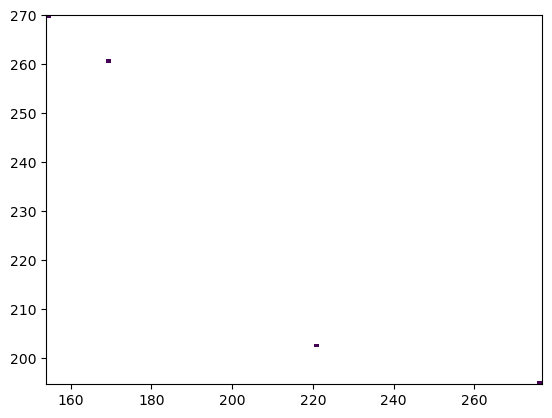

In [137]:
i = 0
plt.hist2d(true_val[0, i, :].flatten().numpy(), reco_val[0, i, :].flatten().numpy(), cmap=cmap, norm = matplotlib.colors.LogNorm(vmax = 500), bins = 100)

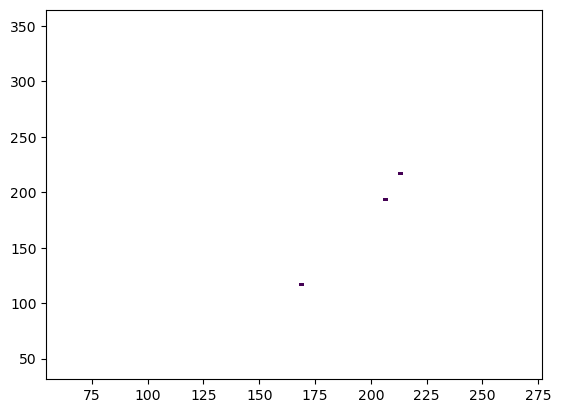

In [138]:
bounds = [(true_val[:, i, :].min(), true_val[:, i, :].max()), (reco_val[:, i, :].min(), reco_val[:, i, :].max())]
h = fast_histogram.histogram2d(true_val[0, i, :], reco_val[0, i, :], range=bounds, bins=100) # get the histogram of the i-th feature for all the events and all the true_valets
plt.imshow(h, cmap=cmap, norm = matplotlib.colors.LogNorm(vmax = 500), extent= [*bounds[0], *bounds[1]], aspect = 'auto')

In [139]:
mse_loss_batch = torch.randn(256, 3, 4)
w = torch.randn(256)
w_sum = w.sum()

loss_batch = ((w * mse_loss_batch.permute(1,2,0)).permute(2,0,1).sum() / w_sum) # multiply weight for all the jet features and recover the original shape of the features 

In [140]:
loss_batch

tensor(-3.4855)

In [141]:
w[0:10] = 0.

In [142]:
mse_loss_batch[0:10]

tensor([[[-5.5184e-01,  1.5398e+00,  1.0036e+00, -7.9479e-01],
         [ 3.0431e+00, -4.5604e-02, -5.6625e-02,  1.0337e+00],
         [ 6.8701e-01,  2.4275e-01, -1.0653e+00, -5.8923e-01]],

        [[ 2.2877e+00, -1.4430e+00,  5.3899e-01, -8.4577e-01],
         [-8.5634e-01,  8.7667e-01, -2.3375e-01, -1.6692e-01],
         [ 9.1963e-01, -1.6021e+00, -4.7411e-01, -1.0523e+00]],

        [[ 6.7672e-01,  6.2667e-01, -4.4925e-01,  7.3747e-01],
         [-1.7553e+00,  4.4683e-01, -6.5483e-01,  7.0216e-01],
         [-1.0277e-02,  2.1062e+00, -7.6208e-03,  2.6376e+00]],

        [[ 4.9210e-01,  2.8172e-01, -1.7542e-01,  6.0924e-01],
         [ 1.2522e+00, -1.4593e-01,  3.6518e-01, -1.2214e+00],
         [-1.3490e+00,  4.5396e-01,  2.4949e-01, -1.0695e+00]],

        [[-6.8216e-01,  1.0638e-01,  4.7913e-01,  1.4433e-01],
         [-1.4462e-01, -9.0516e-01, -1.3491e+00,  1.2281e+00],
         [ 1.5927e-01, -6.3196e-01, -5.1093e-01,  1.0307e+00]],

        [[-1.6904e+00,  6.1748e-01,  1.8039e-

In [143]:
j = torch.randn(123, 3, 4)
j_scaled = j.clone()
rel_j_scaled = torch.zeros((j.shape[0], 3, 3)) # three relative features for 4 jets
rel_j_scaled[:, 0, :] = j_scaled[:, 0, (0,1,2)] + j_scaled[:, 0, (1,2,3)]
rel_j_scaled[:, 1:3, :] = j_scaled[:, 1:3, (0,1,2)] - j_scaled[:, 1:3, (1,2,3)]

In [144]:
rel_j = torch.zeros((j.shape[0], 3, 3)) # three relative features for 4 jets
rel_j_scaled = torch.zeros((j.shape[0], 3, 3)) # the normalized feature vector for loss computation

rel_j[:, 0, :] = j[:, 0, (0,1,2)] + j[:, 0, (1,2,3)] # construct scalar pt of dijets
rel_j[:, 1:3, :] = j[:, 1:3, (0,1,2)] - j[:, 1:3, (1,2,3)] # construct differences of eta and phi (12, 23, 34)


In [145]:
rel_j = torch.zeros((j.shape[0], 3, 3)) # three relative features for 4 jets
rel_j_scaled = torch.zeros((j.shape[0], 3, 3)) # the normalized feature vector for loss computation

rel_j[:, 0, :] = j[:, 0, (0,1,2)] + j[:, 0, (1,2,3)] # construct scalar pt of dijets
rel_j[:, 1:3, :] = (j[:, 1:3, (0,1,2)] - j[:, 1:3, (1,2,3)]).abs() # construct differences of eta and phi (12, 23, 34)

#rel_j[:, 2, :] = 2 * np.pi - rel_j[:, 2, :] if rel_j[:, 2, :] > np.pi else rel_j[:, 2, :] # eliminate redundances -> dPhi in [pi, 2pi] is passed to the range [0, pi] (equivalent to changing the order of the subtraction inside the absolute value)

In [146]:
import networks
rel_j[:, 2:3, (0,1,2)] = networks.Input_Embed.calcDeltaPhi(j[:, 2:3, (0,1,2)], j[:,2:3,(1,2,3)])


TypeError: Input_Embed.calcDeltaPhi() missing 1 required positional argument: 'v2'

In [129]:
a  = torch.Tensor([2.3])
b = torch.Tensor([-1.2])

a / b

tensor([-1.9167])

In [130]:
a//b

/var/folders/nv/28ksfhj10wz9h413w7pr82sc0000gn/T/ipykernel_38613/2860853455.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  a//b


tensor([-1.])

In [131]:
torch.div(a, b, rounding_mode = 'trunc')

tensor([-1.])

In [132]:
torch.div(a, b, rounding_mode = 'floor')

tensor([-2.])

In [149]:
w = torch.zeros(9940)
loss = torch.randn(9940, 3, 3)

In [156]:
(w*loss.permute(1,2,0)).permute(2,0,1).shape

torch.Size([9940, 3, 3])

In [157]:
(w*loss.permute(1,2,0)).permute(2,0,1).shape

torch.Size([9940, 3, 3])

In [163]:
import time

In [183]:
N = 100
time_list = np.zeros(N)
x_ = np.zeros(N)
for k in range(N): # 10 tests
    start = time.time()
    a = torch.Tensor(())
    x_[k] = 10000 + 1000 * k
    for i in range(10000 + 1000 * k): # 10000, 11000, 12000, 13000, 14000, 15000, ... , 20000 
        # if i = torch.tensor(1)
        # it cannot be cat, since it has 
        # zero dimention.
        # Also use .float() to make sure that they 
        # are in the same dtype
        i = torch.Tensor([i]).float()
        a = torch.cat((a, i), 0)
        
    print(a)
    print("time: ", time.time()-start)
    time_list[k] = time.time()-start

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 9.9970e+03, 9.9980e+03,
        9.9990e+03])
time:  0.13714194297790527
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.0997e+04, 1.0998e+04,
        1.0999e+04])
time:  0.08161401748657227
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.1997e+04, 1.1998e+04,
        1.1999e+04])
time:  0.09767031669616699
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.2997e+04, 1.2998e+04,
        1.2999e+04])
time:  0.10048508644104004
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.3997e+04, 1.3998e+04,
        1.3999e+04])
time:  0.1042490005493164
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.4997e+04, 1.4998e+04,
        1.4999e+04])
time:  0.11346602439880371
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.5997e+04, 1.5998e+04,
        1.5999e+04])
time:  0.12796807289123535
tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 1.6997e+04, 1.6998e+04,
        1.6999e+04])
time:  0.13518214225769043
tensor([0.0000e+00, 1.000

Text(0, 0.5, 'Time of append (s)')

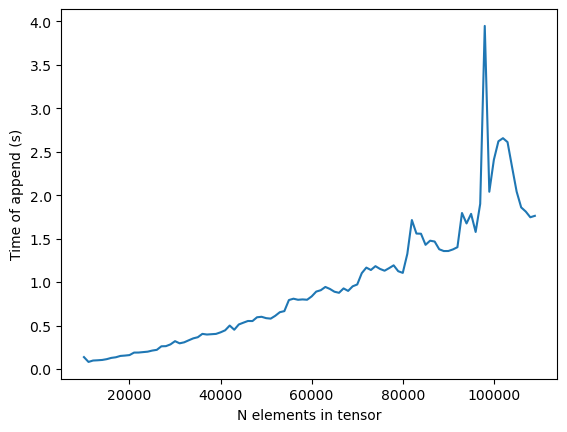

In [184]:
plt.plot(x_, time_list)
plt.xlabel(f"N elements in tensor")
plt.ylabel(f"Time of append (s)")

In [242]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

torch.manual_seed(0)#make training results repeatable 


def vector_print(vector, end='\n'):
    vectorString = ", ".join([f'{element:7.2f}' for element in vector])
    print(vectorString, end=end)

    
class Ghost_Batch_Norm(nn.Module): #https://arxiv.org/pdf/1705.08741v2.pdf has what seem like typos in GBN definition. 
    def __init__(self, features, ghost_batch_size=32, number_of_ghost_batches=64, n_averaging=1, stride=1, eta=0.9, bias=True, device='cpu', name='', conv=False, features_out=None):
        super(Ghost_Batch_Norm, self).__init__()
        self.name = name
        self.index = None
        self.stride = stride
        self.device = device
        self.features = features
        self.features_out = features_out if features_out is not None else self.features
        self.register_buffer('ghost_batch_size', torch.tensor(ghost_batch_size, dtype=torch.long))
        self.register_buffer('n_ghost_batches', torch.tensor(number_of_ghost_batches*n_averaging, dtype=torch.long))
        self.conv = False
        self.gamma = None
        self.bias = None
        self.updates = 0
        if conv:
            self.conv = nn.Conv1d(self.features, self.features_out, stride, stride=stride, bias=bias)
        else:
            self.gamma = nn.Parameter(torch .ones(self.features))
            if bias:
                self.bias = nn.Parameter(torch.zeros(self.features))
        self.running_stats = True
        self.initialized   = False

        self.register_buffer('eps',  torch.tensor(1e-5, dtype=torch.float))
        self.register_buffer('eta',  torch.tensor(eta, dtype=torch.float))
        self.register_buffer('m',    torch.zeros((1,1,self.stride,self.features), dtype=torch.float))
        self.register_buffer('s',    torch.ones ((1,1,self.stride,self.features), dtype=torch.float))
        self.register_buffer('zero', torch.tensor(0., dtype=torch.float))
        self.register_buffer('one',  torch.tensor(1., dtype=torch.float))
        self.register_buffer('two',  torch.tensor(2., dtype=torch.float))

    def print(self):
        print('-'*50)
        print(self.name)
        for i in range(self.stride):
            print(" mean ",end='')
            vector_print(self.m[0,0,i,:])
        for i in range(self.stride):
            print("  std ", end='')
            vector_print(self.s[0,0,i,:])
        if self.gamma is not None:
            print("gamma ", end='')
            vector_print(self.gamma.data)
            if self.bias is not None:
                print(" bias ", end='')
                vector_print(self.bias.data)
        print()
        
    @torch.no_grad()
    def set_mean_std(self, x):
        batch_size = x.shape[0]
        pixels = x.shape[2]
        pixel_groups = pixels//self.stride
        x = x.detach().transpose(1,2).contiguous().view(batch_size*pixels, 1, self.features)
        # this won't work for any layers with stride!=1
        x = x.view(-1, 1, self.stride, self.features)            
        m64 = x.mean(dim=0, keepdim=True, dtype=torch.float64)#.to(self.device)
        self.m = m64.type(torch.float32).to(self.device)
        self.s = x .std(dim=0, keepdim=True).to(self.device)
        self.initialized = True
        self.running_stats = False
        self.print()        

    def set_ghost_batches(self, n_ghost_batches):
        self.n_ghost_batches = torch.tensor(n_ghost_batches, dtype=torch.long).to(self.device)

    def forward(self, x, debug=False):
        batch_size = x.shape[0]
        pixels = x.shape[2]
        pixel_groups = pixels//self.stride

        if self.training and self.n_ghost_batches!=0:
            # this has been changed from self.ghost_batch_size = batch_size // self.n_ghost_batches.abs()
            self.ghost_batch_size = torch.div(batch_size, self.n_ghost_batches.abs(), rounding_mode = 'trunc')

            #
            # Apply batch normalization with Ghost Batch statistics
            #
            x = x.transpose(1,2).contiguous().view(self.n_ghost_batches.abs(), self.ghost_batch_size*pixel_groups, self.stride, self.features)
            
            gbm =  x.mean(dim=1, keepdim=True)
            gbs = (x. var(dim=1, keepdim=True) + self.eps).sqrt()

            #
            # Keep track of running mean and standard deviation. 
            #
            if self.running_stats or debug:
                # Use mean over ghost batches for running mean and std
                bm = gbm.detach().mean(dim=0, keepdim=True)
                bs = gbs.detach().mean(dim=0, keepdim=True)

                if debug and self.initialized:
                    gbms = gbm.detach().std(dim=0, keepdim=True)
                    gbss = gbs.detach().std(dim=0, keepdim=True)
                    m_pulls = (bm-self.m)/gbms
                    s_pulls = (bs-self.s)/gbss
                    #s_ratio = bs/self.s
                    #if (m_pulls.abs()>5).any() or (s_pulls.abs()>5).any():
                    print()
                    print(self.name)
                    print('self.m\n',self.m)
                    print('    bm\n', bm)
                    print('  gbms\n',gbms)
                    print('m_pulls\n',m_pulls,m_pulls.abs().mean(),m_pulls.abs().max())
                    print('-------------------------')
                    print('self.s\n',self.s)
                    print('    bs\n',bs)
                    print('  gbss\n',gbss)
                    print('s_pulls\n',s_pulls,s_pulls.abs().mean(),s_pulls.abs().max())
                    #print('s_ratio\n',s_ratio)
                    print()
                    #input()
                    
            if self.running_stats:
                # Simplest possible method
                if self.initialized:
                    self.m = self.eta*self.m + (self.one-self.eta)*bm
                    self.s = self.eta*self.s + (self.one-self.eta)*bs
                else:
                    self.m = self.zero*self.m+bm
                    self.s = self.zero*self.s+bs
                    self.initialized = True

            if self.n_ghost_batches>0:
                x = x - gbm
                x = x / gbs
            else:
                x = x.view(batch_size, pixel_groups, self.stride, self.features)
                x = x - self.m
                x = x / self.s
                
        else:
            # Use mean and standard deviation buffers rather than batch statistics
            #.view(self.n_ghost_batches, self.ghost_batch_size*pixel_groups, self.stride, self.features)
            x = x.transpose(1,2).view(batch_size, pixel_groups, self.stride, self.features)
            x = x - self.m
            x = x / self.s

        if self.conv:
            # back to standard indexing for convolutions: [batch, feature, pixel]
            x = x.view(batch_size, pixels, self.features).transpose(1,2).contiguous()
            x = self.conv(x)
        else:
            x = x * self.gamma
            if self.bias is not None:
                x = x + self.bias
            # back to standard indexing for convolutions: [batch, feature, pixel]
            x = x.view(batch_size, pixels, self.features).transpose(1,2).contiguous()
        return x            

    
#
# some basic four-vector operations
#
def PxPyPzE(v): # need this to be able to add four-vectors
    pt  = v[:,0:1]
    eta = v[:,1:2]
    phi = v[:,2:3]
    m   = v[:,3:4]
    
    Px, Py, Pz = pt*phi.cos(), pt*phi.sin(), pt*eta.sinh()
    E = (pt**2 + Pz**2 + m**2).sqrt()

    return torch.cat( (Px,Py,Pz,E), 1 )


def PtEtaPhiM(v):
    px = v[:,0:1]
    py = v[:,1:2]
    pz = v[:,2:3]
    e  = v[:,3:4]

    Pt  = (px**2+py**2).sqrt()
    ysign = py.sign()
    ysign = ysign + (ysign==0.0).float() # if py==0, px==Pt and acos(1)=pi/2 so we need zero protection on py.sign()
    Phi = (px/Pt).acos() * ysign
    Eta = (pz/Pt).asinh()

    M = F.relu(e**2 - px**2 - py**2 - pz**2).sqrt()

    return torch.cat( (Pt, Eta, Phi, M) , 1 ) 
    

def addFourVectors(v1, v2, v1PxPyPzE=None, v2PxPyPzE=None): # output added four-vectors
    #vX[batch index, (pt,eta,phi,m), object index]

    if v1PxPyPzE is None:
        v1PxPyPzE = PxPyPzE(v1)
    if v2PxPyPzE is None:
        v2PxPyPzE = PxPyPzE(v2)

    v12PxPyPzE = v1PxPyPzE + v2PxPyPzE
    v12        = PtEtaPhiM(v12PxPyPzE)

    return v12, v12PxPyPzE

def calcDeltaPhi(v1, v2): #expects eta, phi representation
    dPhi12 = (v1[:,2:3]-v2[:,2:3])%math.tau
    dPhi21 = (v2[:,2:3]-v1[:,2:3])%math.tau
    dPhi = torch.min(dPhi12,dPhi21)
    return dPhi

#
# Some different non-linear units
#
def SiLU(x): #SiLU https://arxiv.org/pdf/1702.03118.pdf   Swish https://arxiv.org/pdf/1710.05941.pdf
    return x * torch.sigmoid(x)


def NonLU(x): #Pick the default non-Linear Unit
    return SiLU(x) # often slightly better performance than standard ReLU
    #return F.relu(x)
    #return F.rrelu(x, training=training)
    #return F.leaky_relu(x, negative_slope=0.1)
    #return F.elu(x)
    

#
# embed inputs in feature space
#
class Input_Embed(nn.Module):
    def __init__(self, dimension, device='cpu'):
        super(Input_Embed, self).__init__()
        self.d = dimension
        self.device = device

        # embed inputs to dijetResNetBlock in target feature space
        self.jet_embed     = Ghost_Batch_Norm(3, features_out=self.d, conv=True, name='jet embedder', device=self.device) # phi is relative to dijet, mass is zero in toy data
        self.jet_conv      = Ghost_Batch_Norm(self.d, conv=True, name='jet convolution', device = self.device)

        self.dijet_embed   = Ghost_Batch_Norm(4, features_out=self.d, conv=True, name='dijet embedder', device = self.device) # phi is relative to quadjet
        self.dijet_conv    = Ghost_Batch_Norm(self.d, conv=True, name='dijet convolution', device = self.device) 

        self.quadjet_embed = Ghost_Batch_Norm(3, features_out=self.d, conv=True, name='quadjet embedder', device = self.device) # phi is removed
        self.quadjet_conv  = Ghost_Batch_Norm(self.d, conv=True, name='quadjet convolution', device = self.device)

        #self.register_buffer('tau', torch.tensor(math.tau, dtype=torch.float))

    
        
    def data_prep(self, j):
        j = j.clone()# prevent overwritting data from dataloader when doing operations directly from RAM rather than copying to VRAM
        j = j.view(-1,4,4)

        # make leading jet eta positive direction so detector absolute eta info is removed
        etaSign = 1-2*(j[:,1,0:1]<0).float() # -1 if eta is negative, +1 if eta is zero or positive
        j[:,1,:] = etaSign * j[:,1,:]
        
        d, dPxPyPzE = addFourVectors(j[:,:,(0,2,0,1,0,1)], 
                                     j[:,:,(1,3,2,3,3,2)])

        q, qPxPyPzE = addFourVectors(d[:,:,(0,2,4)],
                                     d[:,:,(1,3,5)], 
                                     v1PxPyPzE = dPxPyPzE[:,:,(0,2,4)],
                                     v2PxPyPzE = dPxPyPzE[:,:,(1,3,5)])        

        # take log of pt, mass variables which have long tails
        j[:,(0,3),:] = torch.log(1+j[:,(0,3),:])
        d[:,(0,3),:] = torch.log(1+d[:,(0,3),:])
        q[:,(0,3),:] = torch.log(1+q[:,(0,3),:])

        # set up all possible jet pairings
        j = torch.cat([j, j[:,:,(0,2,1,3)], j[:,:,(0,3,1,2)]],2)

        # only keep relative angular information so that learned features are invariant under global phi rotations and eta/phi flips
        j[:,2:3,(0,2,4,6,8,10)] = calcDeltaPhi(d, j[:,:,(0,2,4,6,8,10)]) # replace jet phi with deltaPhi between dijet and jet
        j[:,2:3,(1,3,5,7,9,11)] = calcDeltaPhi(d, j[:,:,(1,3,5,7,9,11)])

        d[:,2:3,(0,2,4)] = calcDeltaPhi(q, d[:,:,(0,2,4)])
        d[:,2:3,(1,3,4)] = calcDeltaPhi(q, d[:,:,(1,3,5)])

        q = torch.cat( (q[:,:2,:],q[:,3:,:]) , 1 ) # remove phi from quadjet features

        return j, d, q

    def set_mean_std(self, j):
        j, d, q = self.data_prep(j)

        self    .jet_embed.set_mean_std(j[:,0:3])#mass is always zero in toy data
        self  .dijet_embed.set_mean_std(d)
        self.quadjet_embed.set_mean_std(q)

    def set_ghost_batches(self, n_ghost_batches):
        self.    jet_embed.set_ghost_batches(n_ghost_batches)
        self.  dijet_embed.set_ghost_batches(n_ghost_batches)
        self.quadjet_embed.set_ghost_batches(n_ghost_batches)

        self.    jet_conv.set_ghost_batches(n_ghost_batches)
        self.  dijet_conv.set_ghost_batches(n_ghost_batches)
        self.quadjet_conv.set_ghost_batches(n_ghost_batches)

    def forward(self, j):
        j, d, q = self.data_prep(j)

        j = self    .jet_embed(j[:,0:3])#mass is always zero in toy data
        d = self  .dijet_embed(d)
        q = self.quadjet_embed(q)

        j = self    .jet_conv(NonLU(j))
        d = self  .dijet_conv(NonLU(d))
        q = self.quadjet_conv(NonLU(q))

        return j, d, q


class Basic_CNN(nn.Module):
    def __init__(self, dimension, n_classes=2, device='cpu'):
        super(Basic_CNN, self).__init__()
        self.device = device
        self.d = dimension
        self.n_classes = n_classes
        self.n_ghost_batches = 64

        self.name = f'Basic_CNN_{self.d}'

        self.input_embed = Input_Embed(self.d)

        self.jets_to_dijets     = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)
        self.dijets_to_quadjets = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)

        self.select_q = Ghost_Batch_Norm(self.d, features_out=1, conv=True, bias=False, device = self.device)
        self.out      = Ghost_Batch_Norm(self.d, features_out=self.n_classes, conv=True, device = self.device)

    def set_mean_std(self, j):
        self.input_embed.set_mean_std(j)

    def set_ghost_batches(self, n_ghost_batches):
        self.input_embed.set_ghost_batches(n_ghost_batches)
        self.jets_to_dijets.set_ghost_batches(n_ghost_batches)
        self.dijets_to_quadjets.set_ghost_batches(n_ghost_batches)
        self.select_q.set_ghost_batches(n_ghost_batches)
        self.out.set_ghost_batches(n_ghost_batches)
        self.n_ghost_batches = n_ghost_batches

    def forward(self, j):
        j, d, q = self.input_embed(j)

        d = d + NonLU(self.jets_to_dijets(j))
        q = q + NonLU(self.dijets_to_quadjets(d))

        #compute a score for each event quadjet
        q_logits = self.select_q(q)

        #convert the score to a 'probability' with softmax. This way the classifier is learning which pairing is most relevant to the classification task at hand.
        q_score = F.softmax(q_logits, dim=-1)
        q_logits = q_logits.view(-1, 3)

        #add together the quadjets with their corresponding probability weight
        e = torch.matmul(q, q_score.transpose(1,2))

        #project the final event-level pixel into the class score space
        c_logits = self.out(e)
        c_logits = c_logits.view(-1, self.n_classes)

        return c_logits, q_logits


class Basic_CNN_AE(nn.Module):
    def __init__(self, dimension, out_features = 12, device = 'cpu', construct_rel_features = False):
        super(Basic_CNN_AE, self).__init__()
        self.device = device
        self.d = dimension
        self.out_features = out_features
        self.n_ghost_batches = 64
        self.construct_rel_features = construct_rel_features


        self.name = f'Basic_CNN_AE_{self.d}'

        self.input_embed = Input_Embed(self.d)
        self.jets_to_dijets     = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)
        self.dijets_to_quadjets = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)
        
        self.select_q = Ghost_Batch_Norm(self.d, features_out=1, conv=True, bias=False, device = self.device)


        # any kind of self.out should convert a [batch_size, 8, 1] into a [batch_size, 16, 1]
        self.out_lin = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = self.d, out_features = 10, device = self.device),
            #nn.Dropout(p = 0.2),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features = self.out_features, device = self.device),
            nn.Unflatten(dim = 1, unflattened_size = (self.out_features, 1))
        )


        self.out_GBN      = Ghost_Batch_Norm(self.d, features_out=self.out_features, conv=True, device = self.device)

    
    def set_mean_std(self, j):
        self.input_embed.set_mean_std(j)

    
    def set_ghost_batches(self, n_ghost_batches):
        self.input_embed.set_ghost_batches(n_ghost_batches)
        self.jets_to_dijets.set_ghost_batches(n_ghost_batches)
        self.dijets_to_quadjets.set_ghost_batches(n_ghost_batches)
        self.select_q.set_ghost_batches(n_ghost_batches)
        self.out_GBN.set_ghost_batches(n_ghost_batches)
        self.n_ghost_batches = n_ghost_batches

    def inverse_tfm(self, reconstructed_jets):
        # function to re-apply the inverse transformations to the jets
        return
    
    def forward(self, j):
        j_scaled = j.clone()

        if self.construct_rel_features:
            rel_j = torch.zeros((j.shape[0], 3, 3)) # three relative features for 4 jets
            rel_j_scaled = torch.zeros((j.shape[0], 3, 3)) # the normalized feature vector for loss computation
            
            rel_j[:, 0, :] = j[:, 0, (0,1,2)] + j[:, 0, (1,2,3)] # construct scalar pt of dijets
            rel_j[:, 1, :] = (j[:, 1, (0,1,2)] - j[:, 1, (1,2,3)]).abs() # construct differences of eta (12, 23, 34)
            rel_j[:, 2, (0,1,2)] = calcDeltaPhi(j[:, 2, (0,1,2)], j[:, 2, (1,2,3)]) # eliminate redundances -> dPhi in [pi, 2pi] is passed to the range [0, pi] (equivalent to changing the order of the subtraction inside the absolute value)

            rel_batch_mean = rel_j.mean(dim = (0, 2))
            rel_batch_std = rel_j.std(dim = (0, 2))

        batch_mean = j.mean(dim = (0, 2))
        batch_std = j.std(dim = (0, 2))

            

        j, d, q = self.input_embed(j)
        d = d + NonLU(self.jets_to_dijets(j))
        q = q + NonLU(self.dijets_to_quadjets(d))

        #compute a score for each event quadjet
        q_logits = self.select_q(q)

        #convert the score to a 'probability' with softmax. This way the classifier is learning which pairing is most relevant to the classification task at hand.
        q_score = F.softmax(q_logits, dim=-1)
        q_logits = q_logits.view(-1, 3)

        #add together the quadjets with their corresponding probability weight
        e = torch.matmul(q, q_score.transpose(1,2))

        rec_j = self.out_lin(e)
        rec_j = rec_j.view(-1, 3, 4) # convert to 3x4 events (3 features x 4 jets)

        rec_j_scaled = rec_j.clone()
        rel_rec_j_scaled = rel_j.clone()

        rel_rec_j = torch.zeros((rec_j.shape[0], 3, 3))
        rel_rec_j[:, 0, :] = rec_j[:, 0, (0,1,2)] + rec_j[:, 0, (1,2,3)] # construct scalar pt of dijets
        rel_rec_j[:, 1, :] = (rec_j[:, 1, (0,1,2)] - rec_j[:, 1, (1,2,3)]).abs() # construct differences of eta and phi (12, 23, 34)
        rel_rec_j[:, 2, (0,1,2)] = calcDeltaPhi(rec_j[:, 2, (0,1,2)], rec_j[:,2,(1,2,3)]) # eliminate redundances -> dPhi in [pi, 2pi] is passed to the range [0, pi] (equivalent to changing the order of the subtraction inside the absolute value)

        for i in range(len(rec_j[0, :, 0])):
            # obtained a normalized j for the computation of the loss
            
            j_scaled[:, i, :] = (j_scaled[:, i, :] - batch_mean[i]) / batch_std[i]
            rec_j_scaled[:, i, :] = (rec_j[:, i, :] - batch_mean[i]) / batch_std[i]

            if self.construct_rel_features:
                rel_j_scaled[:, i, :] = (rel_j[:, i, :] - rel_batch_mean[i]) / rel_batch_std[i]
                rel_rec_j_scaled[:, i, :] = (rel_rec_j[:, i, :] - rel_batch_mean[i]) / rel_batch_std[i]
                
        
        
        
        if self.construct_rel_features:
            return rec_j, rec_j_scaled, j_scaled, rel_rec_j, rel_rec_j_scaled, rel_j, rel_j_scaled # output the rec_j, also the scaled variables for loss computation
        else:
            return rec_j, rec_j_scaled, j_scaled, None, None, None # output the rec_j, also the scaled variables for loss computation


class decoder_(nn.Module):
    def __init__(self):
        super(decoder_, self).__init__()
        self.out_lin = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = 8, out_features = 10),
            #nn.Dropout(p = 0.2),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features = 12),
            #nn.Unflatten(dim = 1, unflattened_size = (12, 1))
        )
    def forward(self, x):
        rec_j = self.out_lin(x)
        rec_j = rec_j.view(-1, 3, 3) # convert to 3x4 events (3 features x 4 jets
        return rec_j


In [247]:
x = torch.randn(256, 8)

model = decoder_() # keep for now 4 features for each of the output jet

torch.onnx.export(model, x, "decoder.onnx", verbose=True, input_names=["Embedded"], output_names=["Features"])


Exported graph: graph(%Embedded : Float(256, 8, strides=[8, 1], requires_grad=0, device=cpu),
      %out_lin.1.weight : Float(10, 8, strides=[8, 1], requires_grad=1, device=cpu),
      %out_lin.1.bias : Float(10, strides=[1], requires_grad=1, device=cpu),
      %out_lin.3.weight : Float(12, 10, strides=[10, 1], requires_grad=1, device=cpu),
      %out_lin.3.bias : Float(12, strides=[1], requires_grad=1, device=cpu)):
  %onnx::Gemm_5 : Float(256, 8, strides=[8, 1], requires_grad=0, device=cpu) = onnx::Flatten[axis=1, onnx_name="Flatten_0"](%Embedded) # /opt/miniconda3/envs/coffea_torch/lib/python3.10/site-packages/torch/nn/modules/flatten.py:45:0
  %input : Float(256, 10, strides=[10, 1], requires_grad=1, device=cpu) = onnx::Gemm[alpha=1., beta=1., transB=1, onnx_name="Gemm_1"](%onnx::Gemm_5, %out_lin.1.weight, %out_lin.1.bias) # /opt/miniconda3/envs/coffea_torch/lib/python3.10/site-packages/torch/nn/modules/linear.py:114:0
  %onnx::Gemm_7 : Float(256, 10, strides=[10, 1], requires_grad